In [1]:
import os
from itertools import combinations, permutations
import numpy as np
from Bond import Bond
from types import MappingProxyType
from collections import namedtuple, OrderedDict
from Residue import Residue as Res
from ChMMCIFParser import ChMMCIFParser as ChmParser
from TopoDefinitions import ResidueDefinition
from Atom import Atom
from Residue import Residue
from RTFParser import RTFParser
from ICBuilder import ResidueFixer
from scipy.spatial.transform import Rotation as R
import numpy.linalg as LA

from matplotlib import pyplot as plt

In [2]:
from rdkit.Chem import AllChem

In [2]:
import importlib
import Residue
import ChMMCIFParser
importlib.reload(Residue)
importlib.reload(ChMMCIFParser)
from Residue import Residue as Res
from ChMMCIFParser import ChMMCIFParser as ChmParser

In [3]:
def find_local_cif_path(pdb_id):
    pdb_id = pdb_id.lower()
    entry_point = '/mnt/backup/PDB/'
    subdir = pdb_id[1:3]
    file_path = os.path.join(entry_point, subdir, pdb_id+'.cif')
    if os.path.exists(file_path):
        return file_path

In [4]:
rtf = RTFParser('./data/toppar/top_all36_2_prot.rtf')

/home/truman/whaler/TopoDefinitions.py:164: UserWarning: Unknown Residue Type ALAD! Standard coord build from IC table is skipped.
  warnings.warn(
/home/truman/whaler/TopoDefinitions.py:200: UserWarning: No standard coordinates available. Skipped construction of new residue: ALAD
  warnings.warn(


In [28]:
Parser = ChmParser(
    include_solvent=False
)
pdb_id = '1XBP'
file_path = find_local_cif_path(pdb_id)
structure = Parser.get_structure(file_path)

In [19]:
structure = Parser.get_structure('./3sd3.cif')

In [35]:
structure.model?

Object `structure.model` not found.


In [11]:
chainA = structure[1]['A']
chainA.load_topo_definition(rtf.residue_definitions)

In [15]:
res_builder = ResidueFixer()
for res in chainA:
    if res.topo_definition is None:
        print(f'No topology definition on {res}')
        continue
    res_builder.load_residue(res)
    if res.missing_atoms:
        res_builder.build_missing_atoms()
    res_builder.build_hydrogens()

/home/truman/whaler/ICBuilder.py:199: UserWarning: Missing atoms on terminal residues will be built without patching! Terminal patching is recommended before building missing atoms!
  warnings.warn(


In [16]:
chainA[4].child_list

[<Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>,
 <Atom CB>,
 <Atom CG>,
 <Atom OD1>,
 <Atom OD2>,
 <Atom HN>,
 <Atom HA>,
 <Atom HB1>,
 <Atom HB2>]

In [17]:
chainA[5]

NGLWidget()

<Residue ILE het=  resseq=5 icode= >

In [31]:
structure[1]['FA']

NGLWidget()

<Heterogens id=FA Residues/Molecules=1>
  Description: TIAMULIN

In [34]:
azi = structure[1]['FA'].to_rdkit_mols()[0]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/truman/.conda/envs/pcm-devel/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2602496/292891023.py", line 1, in <module>
    azi = structure[1]['FA'].to_rdkit_mols()[0]
  File "/home/truman/whaler/Chain.py", line 384, in to_rdkit_mols
    self.child_list[0].pdbx_description = self.pdbx_description
  File "/home/truman/whaler/Chain.py", line 384, in <listcomp>
    self.child_list[0].pdbx_description = self.pdbx_description
  File "/home/truman/whaler/Residue.py", line 271, in to_rdkit
  File "/home/truman/whaler/Residue.py", line 84, in get_pdb_str
    for atom in self._get_child(self, include_alt):
  File "/home/truman/.conda/envs/pcm-devel/lib/python3.10/site-packages/Bio/PDB/PDBIO.py", line 249, in _get_atom_line
    return _ATOM_FORMAT_STRING % args
TypeError: %c requires int or char

During handling of the above exceptio

In [38]:
from copy import copy

In [39]:
azi_2d = copy(azi)

In [40]:
AllChem.Compute2DCoords(azi_2d)

0

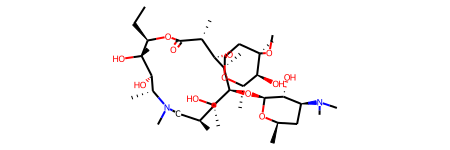

In [41]:
azi

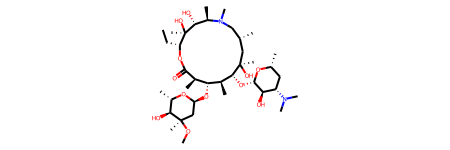

In [42]:
azi_2d

In [9]:
resnames = [
    'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 
    'GLY', 'HSD', 'HSE', 'HSP', 'ILE', 'LEU', 'LYS', 
    'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'
]

for resname in resnames:
    residue = rtf.residue_definitions[resname].create_residue()
    with open(f"./ic_test_pdb/{resname}.pdb", 'w') as f:
        f.write(residue.get_pdb_str())
        f.write('TER\nEND')

In [9]:
rtf.residue_definitions['THR'].create_residue()

NGLWidget()

<Residue THR het=  resseq=0 icode= >

In [30]:
rtf.residue_definitions

{'ALA': <Residue Definition name=ALA code=A atoms=10>,
 'ARG': <Residue Definition name=ARG code=R atoms=24>,
 'ASN': <Residue Definition name=ASN code=N atoms=14>,
 'ASP': <Residue Definition name=ASP code=D atoms=12>,
 'CYS': <Residue Definition name=CYS code=C atoms=11>,
 'GLN': <Residue Definition name=GLN code=Q atoms=17>,
 'GLU': <Residue Definition name=GLU code=E atoms=15>,
 'GLY': <Residue Definition name=GLY code=G atoms=7>,
 'HSD': <Residue Definition name=HSD code=H atoms=17>,
 'HSE': <Residue Definition name=HSE code=H atoms=17>,
 'HSP': <Residue Definition name=HSP code=H atoms=18>,
 'ILE': <Residue Definition name=ILE code=I atoms=19>,
 'LEU': <Residue Definition name=LEU code=L atoms=19>,
 'LYS': <Residue Definition name=LYS code=K atoms=22>,
 'MET': <Residue Definition name=MET code=M atoms=17>,
 'PHE': <Residue Definition name=PHE code=F atoms=20>,
 'PRO': <Residue Definition name=PRO code=P atoms=14>,
 'SER': <Residue Definition name=SER code=S atoms=11>,
 'THR': <Re